<a href="https://colab.research.google.com/github/TXH2020/MainRepo/blob/main/Academics/Image%20Processing/Image_Processing4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Deep Learning Architectures
###Use GPU for running this notebook.

In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [2]:
import gdown
url="https://drive.google.com/uc?id=1K1qmkEUjeibM0WrlMeTxQD6DT2mme4Nt"
gdown.download(url,"data.zip", quiet=True)

'data.zip'

In [3]:
!unzip data.zip
!unzip train.zip
!unzip test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

In [4]:
import os
os.rename("test1","test")

In [5]:
import numpy as np        
import cv2                
from random import shuffle 
from tqdm import tqdm # percentage bar for tasks. 
import matplotlib.pyplot as plt
# download the cats/dogs images compressed train and test datasets from here: https://www.kaggle.com/c/dogs-vs-cats/data
# unzip the train.zip images under the train folder and test.zip images under the test folder
train = './train'      
test = './test'
lr = 1e-6     # learning rate
image_size = 50 # all the images will be resized to squaure images with this dimension

model_name = 'cats_dogs-{}-{}.model'.format(lr, 'conv2') 

In [6]:
def label_image(image):
    word_label = image.split('.')[-3]
    if word_label == 'cat': return 0
    elif word_label == 'dog': return 1

In [7]:
def create_training_data():
    training_data = []
    for image in tqdm(os.listdir(train)):
        path = os.path.join(train, image)
        label = label_image(image)
        image = cv2.imread(path)
        image = cv2.resize(image, (image_size, image_size))
        training_data.append([np.array(image),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [8]:
def create_test_data():
    testing_data = []
    for image in tqdm(os.listdir(test)):
        path = os.path.join(test, image)
        image = cv2.imread(path)
        image = cv2.resize(image, (image_size, image_size))
        testing_data.append(np.array(image))        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [9]:
def testing(model,test_data):
  X_test = np.array([i for i in test_data]).reshape(-1,image_size,image_size,3)
  probs = model.predict(X_test)
  probs = np.round(probs,2)
  plt.figure(figsize=(20,20))
  for i in range(100):
    plt.subplot(10,10,i+1), plt.imshow(X_test[i,:,:,::-1]), plt.axis('off')
    plt.title("{}, prob={:0.2f}".format('cat' if probs[i][1] < 0.5 else 'dog', max(probs[i][0],probs[i][1])))
  plt.show()

In [10]:
train_data = create_training_data()
test_data = create_test_data()

100%|██████████| 25000/25000 [00:52<00:00, 478.72it/s]
/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
100%|██████████| 12500/12500 [00:25<00:00, 488.49it/s]


In [11]:
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.utils import to_categorical

train = train_data[:-5000] # 20k images for training
valid = train_data[-5000:] # 5k images for validation
X_train = np.array([i[0] for i in train]).reshape(-1,image_size,image_size,3)
y_train = [i[1] for i in train]
y_train = to_categorical(y_train)
print(X_train.shape, y_train.shape)

X_valid = np.array([i[0] for i in valid]).reshape(-1,image_size,image_size,3)
y_valid = [i[1] for i in valid]
y_valid = to_categorical(y_valid) # to one-hot encoding

num_classes = y_valid.shape[1] # number of categories

(20000, 50, 50, 3) (20000, 2)


In [12]:
model = VGG16(weights=None, input_shape=(image_size,image_size,3), classes=num_classes) # train VGG16 model from scratch
model.compile(Adam(lr=lr), "categorical_crossentropy", metrics=["accuracy"]) # "adam"
model.summary()

# fit the model, it's going take a long time if not run on GPU
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=40, batch_size=256, verbose=2)
# evaluate the model
scores = model.evaluate(X_valid, y_valid, verbose=0)
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/40
79/79 - 33s - loss: 0.6891 - accuracy: 0.5554 - val_loss: 0.6853 - val_accuracy: 0.5740 - 33s/epoch - 412ms/step
Epoch 2/40
79/79 - 19s - loss: 0.6766 - accuracy: 0.6060 - val_loss: 0.6694 - val_accuracy: 0.6124 - 19s/epoch - 236ms/step
Epoch 3/40
79/79 - 19s - loss: 0.6540 - accuracy: 0.6335 - val_loss: 0.6449 - val_accuracy: 0.6454 - 19s/epoch - 246ms/step
Epoch 4/40
79/79 - 19s - loss: 0.6285 - accuracy: 0.6567 - val_loss: 0.6283 - val_accuracy: 0.6514 - 19s/epoch - 242ms/step
Epoch 5/40
79/79 - 19s - loss: 0.6108 - accuracy: 0.6680 - val_loss: 0.6143 - val_accuracy: 0.6652 - 19s/epoch - 238ms/step
Epoch 6/40
79/79 - 19s - loss: 0.5994 - accuracy: 0.6769 - val_loss: 0.6059 - val_accuracy: 0.6706 - 19s/epoch - 237ms/step
Epoch 7/40
79/79 - 19s - loss: 0.5879 - accuracy: 0.6870 - val_loss: 0.5998 - val_accuracy: 0.6726 - 19s/epoch - 240ms/step
Epoch 8/40
79/79 - 19s - loss: 0.5822 - accuracy: 0.6924 - val_loss: 0.5931 - val_accuracy: 0.6816 - 19s/epoch - 241ms/step
Epoch 9/

391/391 [==============================] - 6s 15ms/step


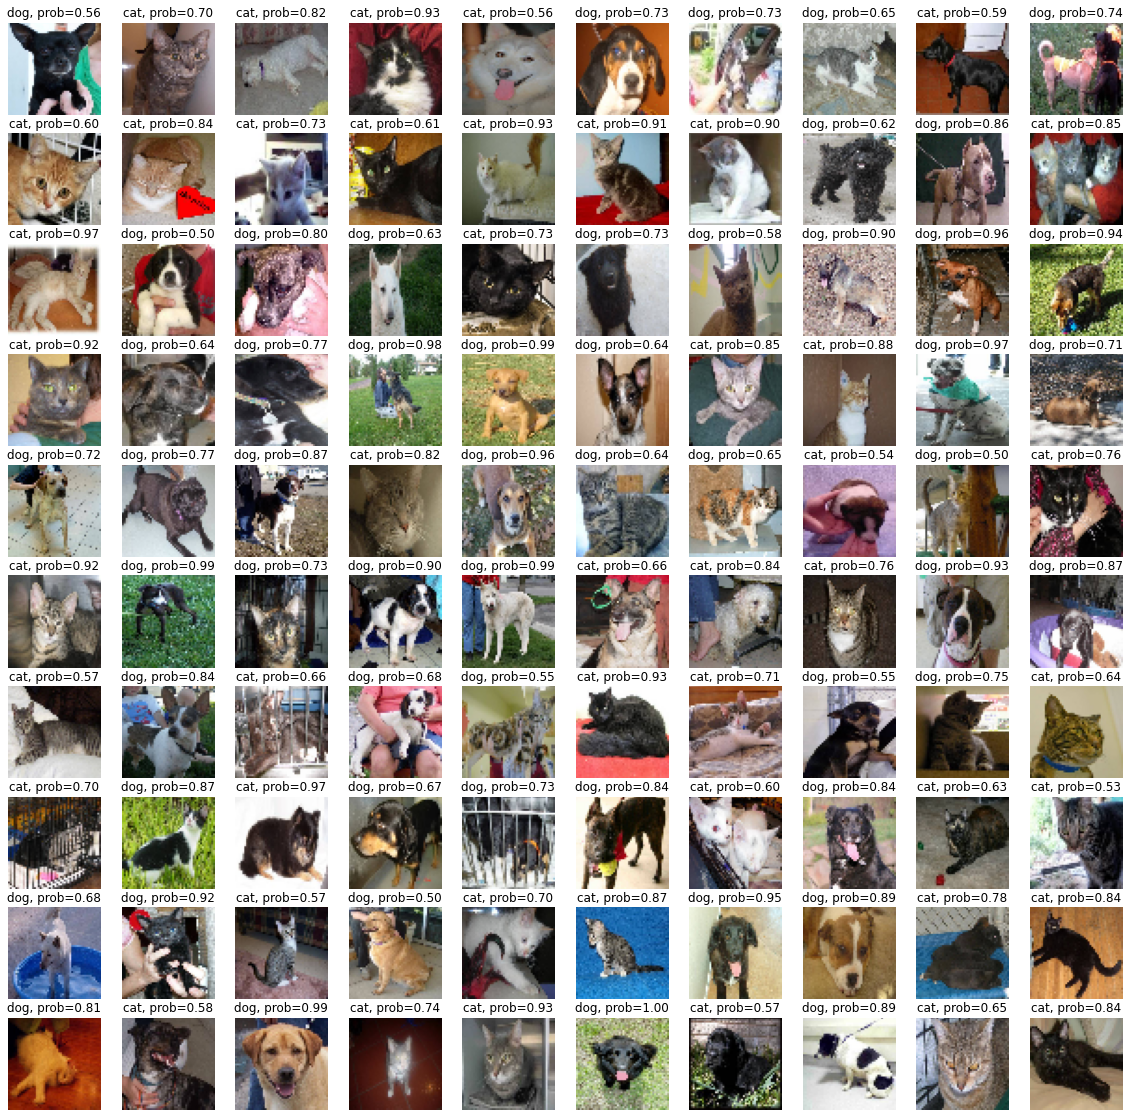

In [13]:
testing(model,test_data)

In [14]:
from keras.applications.vgg19 import VGG19
model = VGG19(weights=None, input_shape=(image_size,image_size,3), classes=num_classes) # train VGG19 model from scratch
model.compile(Adam(lr=lr), "categorical_crossentropy", metrics=["accuracy"]) # "adam"
model.summary()

# fit the model, it's going take a long time if not run on GPU
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=40, batch_size=256, verbose=2)
# evaluate the model
scores = model.evaluate(X_valid, y_valid, verbose=0)
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

391/391 [==============================] - 7s 17ms/step


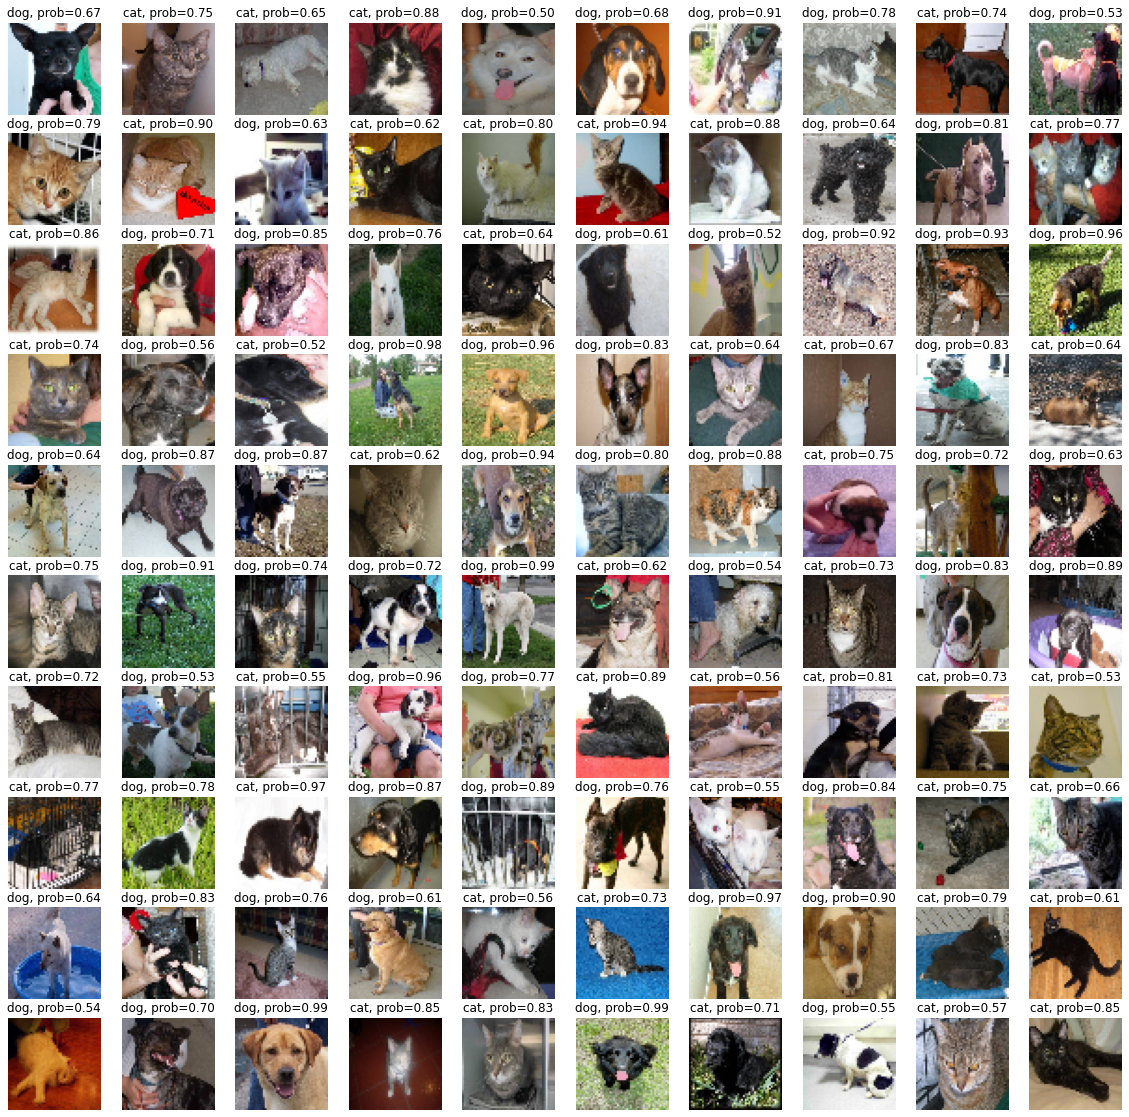

In [15]:
testing(model,test_data)

In [16]:
from keras.applications.resnet import ResNet50
model = ResNet50(weights=None, input_shape=(image_size,image_size,3), classes=num_classes) # train resnet model from scratch
model.compile(Adam(lr=lr), "categorical_crossentropy", metrics=["accuracy"]) # "adam"
model.summary()

# fit the model, it's going take a long time if not run on GPU
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=40, batch_size=256, verbose=2)
# evaluate the model
scores = model.evaluate(X_valid, y_valid, verbose=0)
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 56, 56, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 25, 25, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 25, 25, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

391/391 [==============================] - 7s 15ms/step


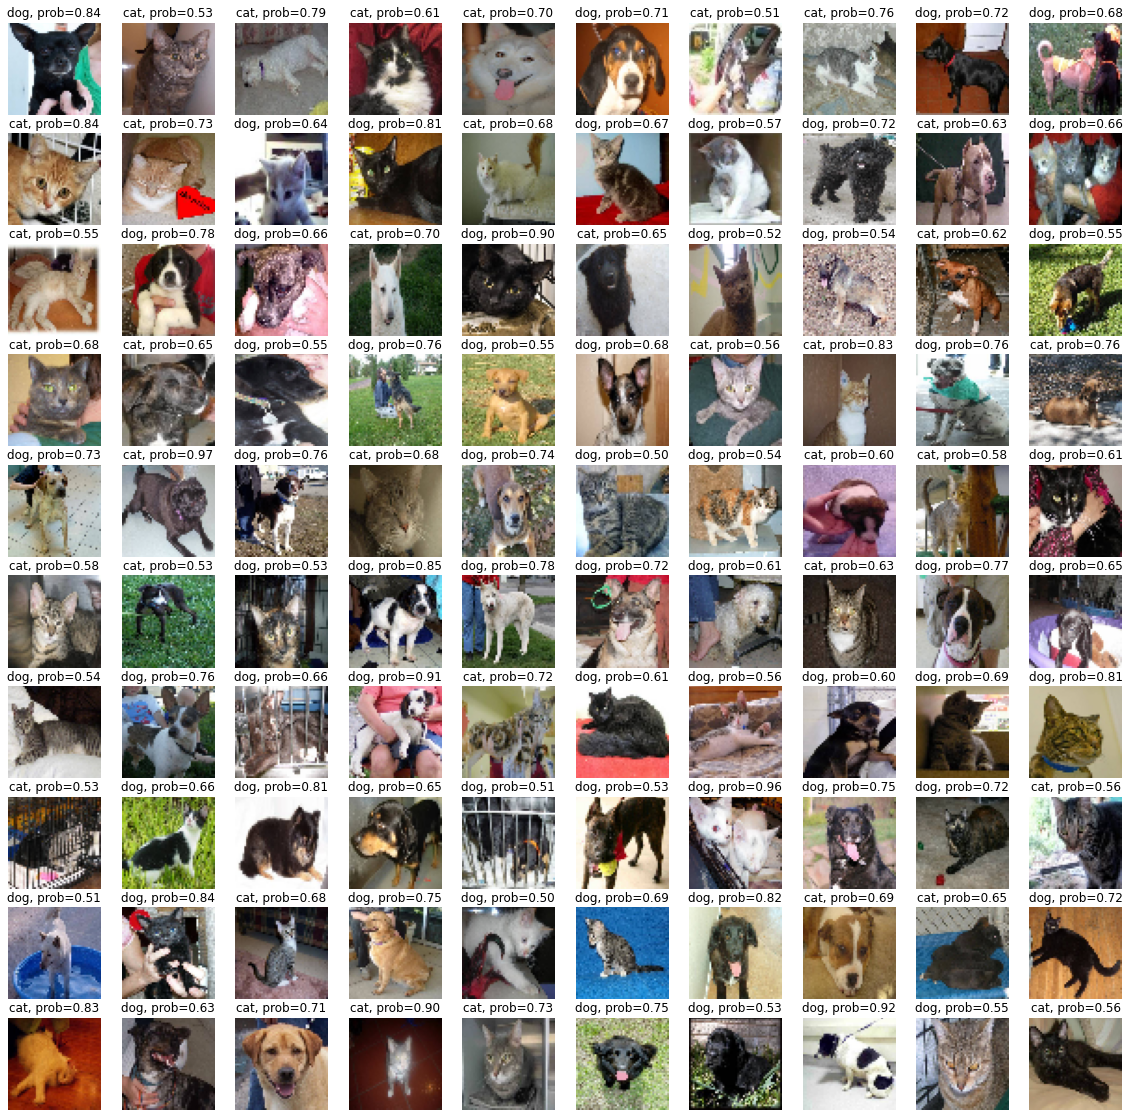

In [17]:
testing(model,test_data)